# Forecasting with the Long Short-Term Memory (LSTM) Network

[LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) is a type of recurrent neural network (RNN) architecture capable of learning long-term dependencies. LSTM is a well-suited tool to approximate a highly nonlinear approximation. LSTM uses computation graphs to approximate functions. Further information on LSTM computational units can be found [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).
The LSTM in this project is implemented in Keras. The steps applied are:
1. Prepare LSTM data
   + LSTM in Keras requires time series to be transformed into supervised learning, into input and output data. The data also need to be normalized within the scale of the activation function used by the network.
2. Develop LSTM model
   + Network parameters need to be specified
      + Batch size 
      + Number of neurons
      + Number hidden layer
      + Optimizer
      + Loss function
      + Number of iteration (epoch)
3. Validate forecast
   + A testing data set will be used to evaluate network performance.
4. Parameter tuning
   + Model parameters will be tuned to optimize performance by training LSTM network under a different configuration of neurons, bach size, and epoch.

## Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from datetime import datetime
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
# set seed before importing keras to change default shuffle argument to false
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.utils import np_utils
from keras.layers import Flatten
import warnings

yakima_450_discharge = pd.read_csv('yakima_450_discharge.csv') # saved copy from cleaned and transformed data
yakima_540 = yakima_450_discharge.copy()
yakima_540 = yakima_450_discharge.set_index('date')
yakima_540.index = pd.to_datetime(yakima_540.index)

Using TensorFlow backend.


## Naive (Baseline) Forecast
The baseline forecast is used to understand how well the observed data at a prior time step (t-1) predict the observation at the current time step (t). A baseline forecast performance also gives an idea of how well all other models will actually perform on on this problem. This provides a lower acceptable bound of model performance.

In [81]:
dat = yakima_540.values

# data at time t
train_data = dat[:int(len(dat)*0.5)]
test_data = dat[int(len(dat)*0.5):len((dat))]


history = [x for x in train_data]
predictions = list()
for i in range(len(test_data)):
    # make prediction
    predictions.append(history[-7])
    # observation
    history.append(test_data[i])
# report performance
rmse_naive = np.sqrt(mean_squared_error(test_data, predictions))
print('RMSE: %.3f' % rmse_naive)

RMSE: 1587.685


## Import Performance 

In [54]:
performance = pd.read_csv('Performance.csv')
performance

,Model,Data Period,Mean Absolute Scaled Error (MASE),Root Mean squared Error (RMSE),Mean Absolue Percent Error (MAPE)
0,Naive Forcast,12 months,-,2067.0,21.0
1,One-stop ahead forcast,12 months,670,476.0,79.0
2,Dynamic forcast,12 months,62,2669.0,58.0
3,Naive Forcast,January,-,2831.0,37.0
4,One-stop ahead forcast,January,50,385.0,46.0
5,Dynamic forcast,January,132,1281.0,67.0


## Prepare LSTM Data 
+ Transform the time series into a supervised learning problem
+ Transform the observations to have a specific scale

Text(0.5, 1.0, 'Mean Daily Discharge in Cubic feet per Second')

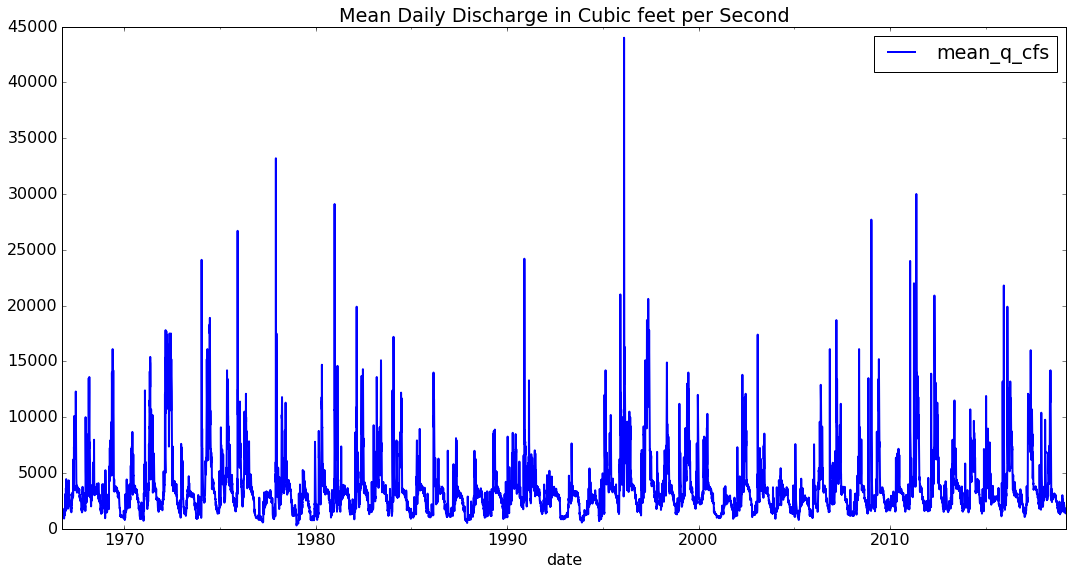

In [86]:
plt.style.use('classic')
%matplotlib inline
rcParams['figure.figsize'] = 18, 9
plt.rcParams.update({'font.size': 16})
yakima_540.plot(linewidth=2.0)
plt.title('Mean Daily Discharge in Cubic feet per Second')

In [4]:
# get time series values
def data_values(df):
    dataframe = df.copy()
    df = dataframe.values
    dataset = df.astype('float32')
    return df

In [5]:
dataset = data_values(yakima_540)

#### Transform the scale of data

In [6]:
# normalize the dataset
def normalize(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df = scaler.fit_transform(df)
    return scaler, df

In [7]:
warnings.filterwarnings("ignore")
scaler, dataset = normalize(dataset)

#### Split into training and testing data sets

In [100]:
# split into train and test sets
def split_data(df):
    train_size = int(len(df) * 0.67)
    test_size = len(df) - train_size
    train, test = df[0:train_size-33,:], df[train_size:len(df)-20,:]
    print('Train size : ' + str(len(train)) + ', Test size : ' + str(len(test)))
    return train, test

In [101]:
train, test = split_data(dataset)

Train size : 12804, Test size : 6304


### Transform the time series into a supervised learning problem

The data is splittd into input x (observation at past time step(t-1)) and output y (observation at current time step(t)). 

In [102]:
def supervised_dataset(dataset, window = 1):
    data_x, data_y = [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+ window), 0]
        data_x.append(a)
        data_y.append(dataset[i + window, 0])
    return np.array(data_x), np.array(data_y)

In [103]:
# reshape into X=t and Y=t+1
window = 3
trainX, trainY = supervised_dataset(train, window)
testX, testY = supervised_dataset(test, window)

### Reshape data into [sample, timesteps, features]

In [104]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

### Fit Stateful LSTM Network model to the Training Data

A stacked LSTM model, rendered "stateful," is implemented that is capable of processing longer sequences. Two LSTM layers are stacked for higher level temporal representation. For the initial run, 50 units (neuron) is used to develop the initial model. 

In [105]:
# create and fit the LSTM network
batch_size = 10
model = Sequential()
model.add(LSTM(50, batch_input_shape=(batch_size, window, 1), stateful=True, return_sequences = True))
model.add(LSTM(50, batch_input_shape=(batch_size, window, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [106]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_105 (LSTM)              (10, 3, 50)               10400     
_________________________________________________________________
lstm_106 (LSTM)              (10, 50)                  20200     
_________________________________________________________________
dense_53 (Dense)             (10, 1)                   51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [108]:
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs = 10, batch_size=batch_size, 
                    verbose = 2, shuffle = False)
model.reset_states()

Train on 12800 samples, validate on 6300 samples
Epoch 1/10
 - 7s - loss: 5.0763e-04 - val_loss: 3.7780e-04
Epoch 2/10
 - 8s - loss: 3.5472e-04 - val_loss: 3.8305e-04
Epoch 3/10
 - 8s - loss: 3.1513e-04 - val_loss: 3.6409e-04
Epoch 4/10
 - 8s - loss: 2.9516e-04 - val_loss: 3.8900e-04
Epoch 5/10
 - 8s - loss: 2.8258e-04 - val_loss: 3.7080e-04
Epoch 6/10
 - 8s - loss: 2.7256e-04 - val_loss: 3.4963e-04
Epoch 7/10
 - 8s - loss: 2.6639e-04 - val_loss: 3.3768e-04
Epoch 8/10
 - 8s - loss: 2.6334e-04 - val_loss: 3.3021e-04
Epoch 9/10
 - 8s - loss: 2.6172e-04 - val_loss: 3.2589e-04
Epoch 10/10
 - 7s - loss: 2.5918e-04 - val_loss: 3.1926e-04


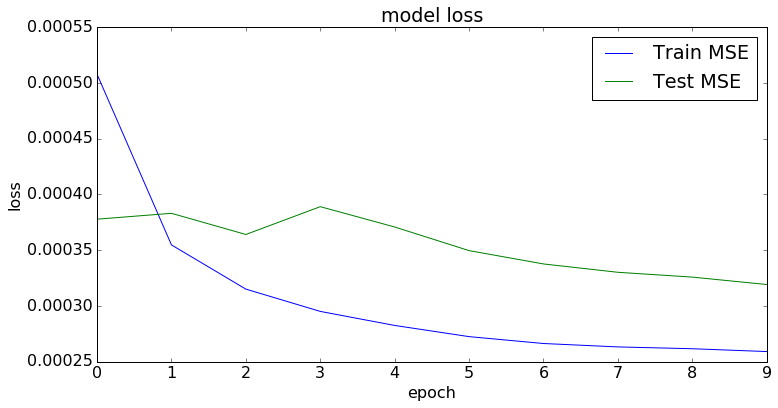

In [110]:
plt.style.use('classic')
%matplotlib inline
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train MSE', 'Test MSE'], loc='upper right')
plt.show()

fig.savefig('Epoch_allmonths.png', dpi=500)

In [16]:
# make predictions
trainPredict = model.predict(trainX, batch_size = batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size = batch_size)

In [17]:
# invert predictions
testPredict = model.predict(testX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [18]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 744.52 RMSE
Test Score: 778.91 RMSE


The RSME on training and testing is better than the naive RMSE, 1587.685.

In [19]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window:len(trainPredict)+window, :] = trainPredict

In [20]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window*2)+4:len(dataset)-51, :] = testPredict

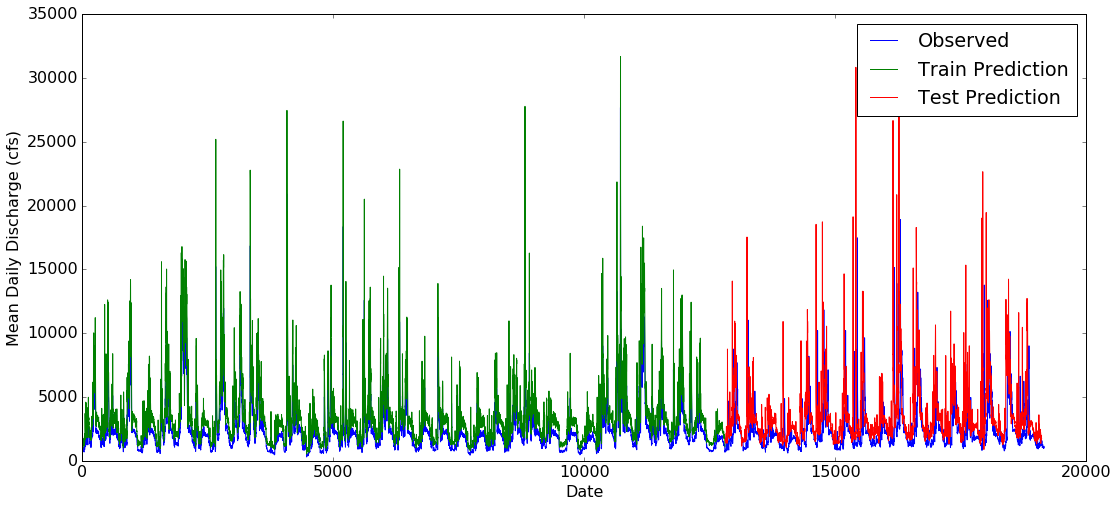

In [111]:
# plot baseline and predictions
plt.style.use('classic')
%matplotlib inline
fig = plt.figure(figsize=(18,8))
plt.rcParams.update({'font.size': 16})
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Observed', 'Train Prediction', 'Test Prediction'])
plt.ylabel('Mean Daily Discharge (cfs)')
plt.xlabel('Date')
plt.show()

fig.savefig('Validation_allmonths.png', dpi=500)

#### LSTM Hyperparameter Tuning

Here are a few ideas to keep in mind when manually optimizing hyperparameters for RNNs:

+ Watch out for overfitting, which happens when a neural network essentially “memorizes” the training data. 
+ Train over multiple epochs (complete passes through the dataset).
+ Evaluate test set performance at each epoch to know when to stop (early stopping).
      
**Epoch**--experiment with 1-10 
**Batch size** -- controls how often  to update the weights of the network
**Number of neurons**

In [25]:
def lstm_fit(train, test, neurons, window, batch_size, epoch):
    
    trainX, trainY = supervised_dataset(train, window)
    testX, testY = supervised_dataset(test, window)
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

    # fit LSTM
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, window, 1), stateful = True, return_sequences = True))
    model.add(LSTM(neurons, batch_input_shape=(batch_size, window, 1), stateful = True))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer='adam')
    
    history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=epoch, batch_size=batch_size, verbose = 0, shuffle = False)
    model.reset_states()
    
    # make prediction
    trainPredict = model.predict(trainX, batch_size=batch_size)
    model.reset_states()
    testPredict = model.predict(testX, batch_size=batch_size)
    
    # invert predictions
    testPredict = model.predict(testX, batch_size=batch_size)
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    
    # calculate root mean squared error
    train_rmse = int(np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0])))
    #print('Train Score: %.2f RMSE' % (trainScore))
    test_rmse = int(np.sqrt(mean_squared_error(testY[0], testPredict[:,0])))
    test_mape = int(np.mean(np.abs((testY[0] - testPredict[:,0]) / testY[0])) * 100)
    test_mase = int(np.sqrt(test_rmse)/rmse_naive)*100
    
    #print('Test Score: %.2f RMSE' % (testScore))
    return train_rmse, test_rmse, test_mape, test_mase

#### Experminent under diffiferent bach size configuration

In [26]:
rmse_bc = {}
mape_bc = {}
mase_bc = {}

for i in np.arange(1,100,1):
    if (len(train)-4)%i==0 and (len(test)-4)%i==0:
        train_rmse, test_rmse, test_mape, test_mase = lstm_fit(train, test, 5, 3, i, 10)
        rmse_bc[i] = test_rmse
        mape_bc[i] = test_mape
        mase_bc[i] = test_mase

In [27]:
min(zip(rmse_bc.values(), rmse_bc.keys()))

(781, 2)

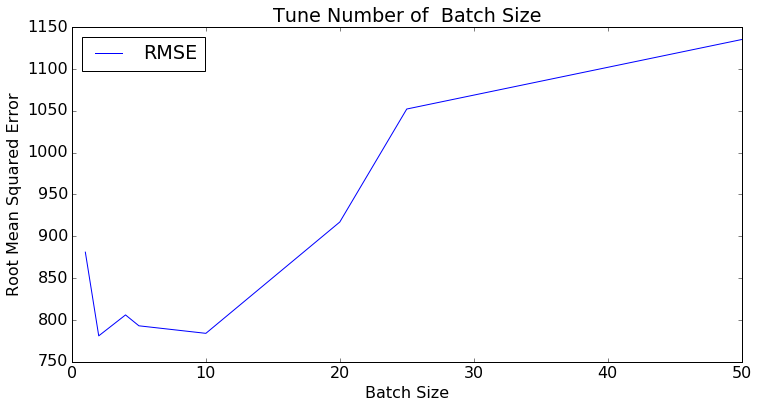

In [112]:
plt.style.use('classic')
%matplotlib inline
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})
plt.plot(rmse_bc.keys(), rmse_bc.values())
plt.title('Tune Number of  Batch Size')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Batch Size')
plt.legend(['RMSE'], loc = 2)
plt.show()

fig.savefig('Batchsize_allmonths.png', dpi=500)

With a range of 1 to 100 bach sizes, the network is performed best at batch size of 2 and 10.

#### Experiment with different number of neurons

In [42]:
rmse_n = {}
mape_n = {}
mase_n = {}

for i in range (1,11):
    train_rmse, test_rmse, test_mape, test_mase = lstm_fit(train, test, i, 3, 10, 10)
    rmse_n[i] = test_rmse
    mape_n[i] = test_mape
    mase_n[i] = test_mase

In [43]:
min(zip(rmse_n.values(), rmse_n.keys()))

(762, 10)

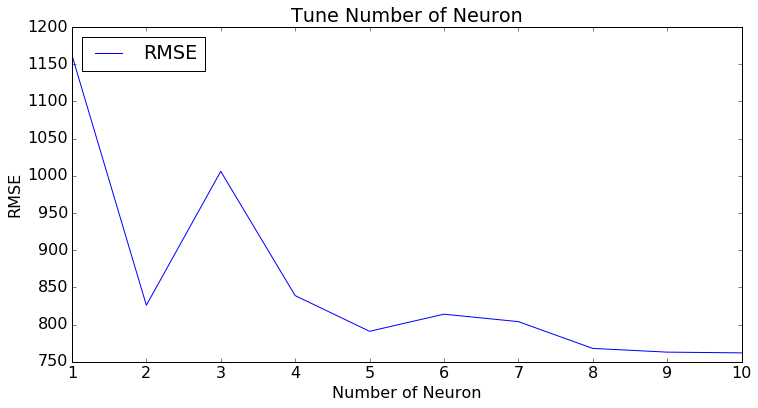

In [113]:
plt.style.use('classic')
%matplotlib inline
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})
plt.plot(rmse_n.keys(), rmse_n.values())
plt.title('Tune Number of Neuron')
plt.ylabel('RMSE')
plt.xlabel('Number of Neuron')
plt.legend(['RMSE'], loc = 2)
plt.show()

fig.savefig('Neuron_allmonths.png', dpi=500)

The network improves its performance as the number of neurons used increased from 1 to 10. The best network was obtained at 10 number of neurons with RMSE score 762 on testing time series. 

In [49]:
# lstm_fit(train, test, neurons, window, batch_size, epoch)
train_rmse, test_rmse, test_mape, test_mase = lstm_fit(train, test, 10, 3, 10, 10)
test_rmse

762

In [55]:
row = performance.shape[0]
performance.loc[row] = ['LSTM', '12 months', test_mase, test_rmse, test_mape]

In [56]:
performance

,Model,Data Period,Mean Absolute Scaled Error (MASE),Root Mean squared Error (RMSE),Mean Absolue Percent Error (MAPE)
0,Naive Forcast,12 months,-,2067.0,21.0
1,One-stop ahead forcast,12 months,670,476.0,79.0
2,Dynamic forcast,12 months,62,2669.0,58.0
3,Naive Forcast,January,-,2831.0,37.0
4,One-stop ahead forcast,January,50,385.0,46.0
5,Dynamic forcast,January,132,1281.0,67.0
6,LSTM,12 months,0,762.0,7.0


The LSTM network trained with 12 months record outperforms naive forecast on RMSE and MAPE, which indicates LSTM is more powerful than  ARIMA model in these data sets.

## Fit LSTM with Lowest Discharge Month
The January time series (the month with lowest discharge record) is used to train LSTM network.

In [57]:
jan_q_cfs = yakima_540[yakima_540.index.month==1]
jan_q_cfs.index

DatetimeIndex(['1967-01-01', '1967-01-02', '1967-01-03', '1967-01-04',
               '1967-01-05', '1967-01-06', '1967-01-07', '1967-01-08',
               '1967-01-09', '1967-01-10',
               ...
               '2019-01-22', '2019-01-23', '2019-01-24', '2019-01-25',
               '2019-01-26', '2019-01-27', '2019-01-28', '2019-01-29',
               '2019-01-30', '2019-01-31'],
              dtype='datetime64[ns]', name='date', length=1643, freq=None)

### Transform data

In [58]:
# separate data values
jan_q_cfs = jan_q_cfs.copy()
dataset_j = data_values(jan_q_cfs)
# normalize data into (0,1) scale
scaler, dataset_j = normalize(dataset_j)

# split data 
train_size_j = int(len(dataset_j) * 0.87)
test_size_j = len(dataset_j) - train_size_j
train_j, test_j = dataset_j[0:train_size_j-25,:], dataset_j[train_size_j-10:len(dataset_j),:]
print('Train size : ' + str(len(train_j)) + ', Test size : ' + str(len(test_j)))

Train size : 1404, Test size : 224


### Train LSTM

In [61]:
# lstm_fit(train, test, neurons, window, batch_size, epoch)
train_j_rmse, test_j_rmse, test_j_mape, test_j_mase = lstm_fit(train_j, test_j, 8, 3, 10, 100)
test_j_rmse

770

#### Experiment with different number of epoch 
As the time series size, January record, is relatively small, we can experiment using a higher number of epochs.

In [62]:
rmse_e_j = {}
mape_e_j = {}
mase_e_j = {}

for i in np.arange(100,1000, 100):
    train_rmse, test_rmse, test_mape, test_mase = lstm_fit(train_j, test_j, 8, 3, 10, i)
    rmse_e_j[i] = test_rmse
    mape_e_j[i] = test_mape
    mase_e_j[i] = test_mase

In [71]:
#sort(zip(rmse_e_j.values(), rmse_e_j.keys()))
sorted(rmse_e_j.items(), key=lambda kv: kv[1])

[(700, 685),
 (200, 697),
 (300, 701),
 (500, 730),
 (400, 777),
 (600, 782),
 (800, 785),
 (100, 840),
 (900, 1751)]

The optimum network is obtained at epoch 700, 200, and 300. Epoch 200 seems a good size as it will minimize time complexities.

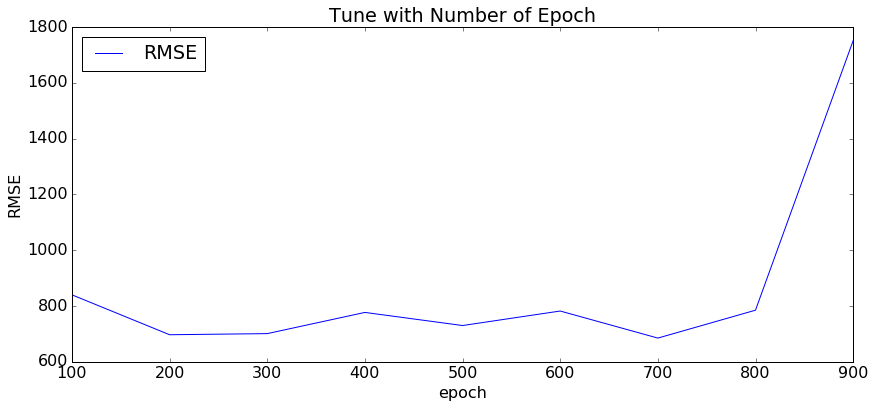

In [114]:
plt.style.use('classic')
%matplotlib inline
fig = plt.figure(figsize=(14,6))
plt.rcParams.update({'font.size': 16})
plt.plot(rmse_e_j.keys(), rmse_e_j.values())
plt.title('Tune with Number of Epoch')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['RMSE'], loc = 2)
plt.show()

fig.savefig('Epoch_January.png', dpi=500)

#### Experminent under diffiferent bach size configuration

In [73]:
rmse_bs_j = {}
mape_bs_j = {}
mase_bs_j = {}

for i in np.arange(2,100,1):
    if (len(train_j)-4)%i==0 and (len(test_j)-4)%i==0:
        train_rmse, test_rmse, test_mape, test_mase = lstm_fit(train_j, test_j, 8, 3, i, 200)
        rmse_bs_j[i] = test_rmse
        mape_bs_j[i] = test_mape
        mase_bs_j[i] = test_mase

In [74]:
min(zip(rmse_bs_j.values(), rmse_bs_j.keys()))

(638, 2)

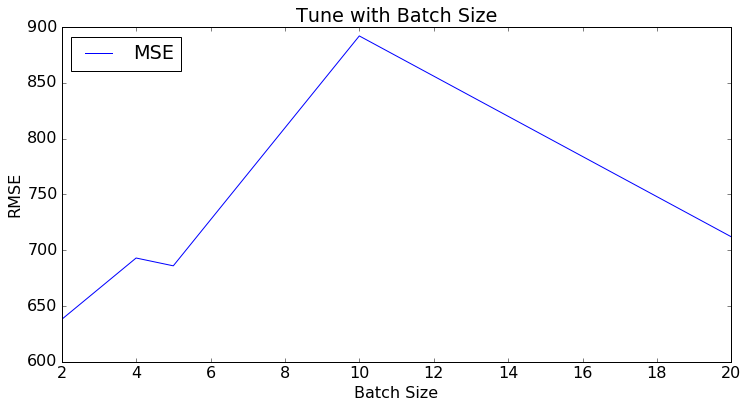

In [115]:
plt.style.use('classic')
%matplotlib inline
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})
plt.plot(rmse_bs_j.keys(), rmse_bs_j.values())
plt.title('Tune with Batch Size')
plt.ylabel('RMSE')
plt.xlabel('Batch Size')
plt.legend(['MSE'], loc = 2)
plt.show()

fig.savefig('Bachsize_January.png', dpi=500)

In [80]:
# lstm_fit(train, test, neurons, window, batch_size, epoch)
train_rmse_j, test_rmse_j, test_mape_j, test_mase_j = lstm_fit(train_j, test_j, 10, 3, 2, 200)
test_rmse_j

756

In [82]:
row = performance.shape[0]
performance.loc[row] = ['LSTM', 'January', test_mase_j, test_rmse_j, test_mape_j]

In [120]:
performance

,Model,Data Period,Mean Absolute Scaled Error (MASE),Root Mean squared Error (RMSE),Mean Absolue Percent Error (MAPE)
0,Naive Forcast,12 months,-,2067.0,21.0
1,One-stop ahead forcast,12 months,670,476.0,79.0
2,Dynamic forcast,12 months,62,2669.0,58.0
3,Naive Forcast,January,-,2831.0,37.0
4,One-stop ahead forcast,January,50,385.0,46.0
5,Dynamic forcast,January,132,1281.0,67.0
6,LSTM,12 months,0,762.0,7.0
7,LSTM,January,0,756.0,18.0


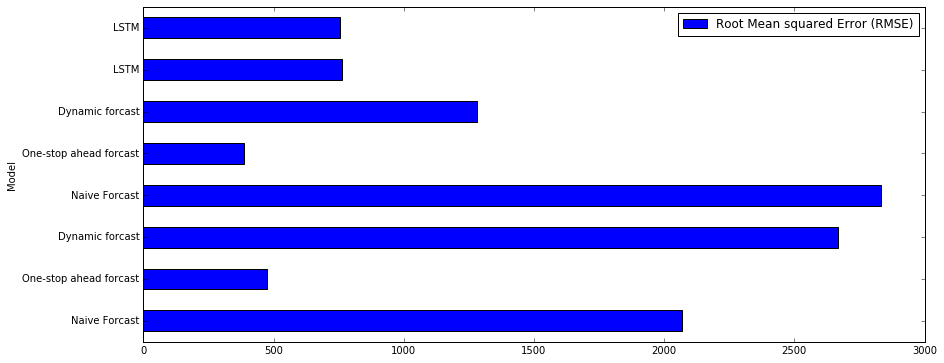

In [170]:
performance.plot(kind = 'barh', x= 'Model', y= 'Root Mean squared Error (RMSE)', figsize=(14,6))

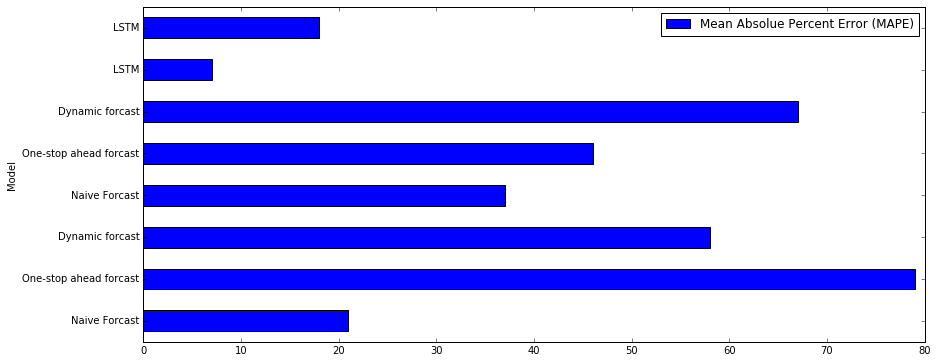

In [171]:
performance.plot(kind = 'barh', x= 'Model', y = 'Mean Absolue Percent Error (MAPE)', figsize=(14,6))

In [121]:
performance.to_csv('performance.csv')

### Conclusion

The performance of ARIMA and LSTM is compared in river flow forecast. These methods were implemented in two scenarios, forecast using all seasons record (12 months) and using the lowest flow season daily record (January). On all season time series, LSTM prediction accuracy was superior to ARIMA (refer the ARIMA dynamic forecast case. The one-step-forecast performance is not compared as it was trained with all data). The use of January time series improved the prediction accuracy of the two methods. From this preliminary result, we can conclude that LSTM method is an effective method for forecasting river flow. The proposed method can be applied in other regions with similar environmental setup. In order to improve the prediction accuracy to the desired level,  advanced hyperparameter tuning with a higher number of river flow data is suggested.  